In [1]:
import random
import os
import csv
import ast

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d


from scipy.stats import *
from astropy.stats import knuth_bin_width
from sklearn.neighbors import *
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import learning_curve
from voxelize_gpu import Voxelize

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


| filename       | type(simulated/real) | class(benign/malignant) | voxel                    |
|----------------|----------------------|-------------------------|--------------------------|
| real/00000.bin | real                 | benign                  | "(00 000 000 000 00 00)" |

In [2]:

class RowEntry:
    def __init__(self, filename):
        self.filename: str=filename
        self.type:str=self.filename.split('/')[0].split('_')[0]
        self.class_:int=0
        self.voxel:str=""


    def to_csv(self):
        return [self.filename, self.type, self.class_, self.voxel]

In [3]:
file=open("filetracker.csv","+w",newline="")
writer=csv.writer(file)
writer.writerow(["filename","type(sim/real)","class(Benign=0/Malignant=1)","Voxel"])
def add_entries(dirname):
    for roots, dirs, files in os.walk(dirname):
        for filenames in files:
            entry_ = RowEntry(f"{dirname}/{filenames}")
            writer.writerow(entry_.to_csv())
add_entries("real_world_training")
add_entries("simulated_training")
file.close()


# store information about every file as to its name and whether or not is benign or malignant




### Poisoning the data

In [4]:
df=pd.read_csv("filetracker.csv", header=0)
poison_percent=0.05
idx:list=[random.randint(0,len(df)-1) for i in range(int(poison_percent*len(df))) ]
df.loc[idx,"class(Benign=0/Malignant=1)"]=1
df.to_csv("filetracker_poisoned.csv",index=False)

### Voxelize the data into around 20 features after converting into readable information. Write this text back into the csv file tha will store the struct.

### Adding Voxels


In [5]:
df=pd.read_csv("filetracker_poisoned.csv", header=0)
df = df.head(5)
df['Voxel'] = [
    str(tuple(Voxelize(np.fromfile(fname, dtype=np.float32).reshape(-1, 4)).voxel()))
    for fname in df['filename']
]
df.to_csv("filetracker_poisoned_voxelized.csv",index=False)



/root/.pyenv/versions/3.11.12/lib/python3.11/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


### Preprocessing

In [6]:
df=pd.read_csv("filetracker_poisoned_voxelized.csv", header=0)
y_data=df['class(Benign=0/Malignant=1)'].to_numpy()
x_data=df['Voxel'].to_numpy()
x_data=[ast.literal_eval(i) for i in x_data]
x_data=np.array(x_data)


# adding noise in simulated.
noise_level=1e-5
x_data_noisy=x_data.copy()
indices=df.index[df['type(sim/real)']=='simulated']
x_data_noisy[indices] += np.random.normal(0, noise_level,x_data_noisy[indices].shape )











### Conducting Detailed Ananlysis using differnt ML classifiers.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    x_data_noisy, y_data, test_size=0.5, random_state=42, stratify=None
)

if len(np.unique(y_train)) < 2:
    print('Not enough classes for classification')
else:
    rf = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    print('RandomForest accuracy:', test_acc)


Not enough classes for classification


# POint cloud processing for reference

In [8]:
point_cloud = np.fromfile('real_08600.bin', dtype=np.float32).reshape(-1, 4)
print(type(point_cloud))
print(point_cloud.shape)
np.savetxt("converted.txt", point_cloud, fmt="%.6f", delimiter=",")
print(len(point_cloud))

<class 'numpy.ndarray'>
(14952, 4)
14952


### Visulaisation in matplotlib

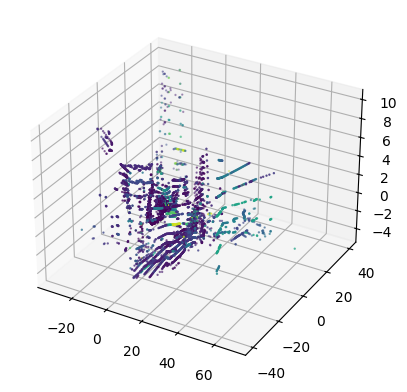

In [9]:
x, y, z, r = point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], point_cloud[:, 3]
r_norm = (r - r.min()) / (r.max() - r.min())

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=r_norm, cmap='viridis', s=0.5)
plt.show()

## Visualisation in open3d

In [10]:
pcd=o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud[:, :3])
pcd.colors=o3d.utility.Vector3dVector(np.stack([r_norm, np.zeros_like(r_norm), np.zeros_like(r_norm)], axis=1))
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(
    pcd,
    voxel_size=0.2  # uniform 0.2m grid
)
o3d.visualization.draw_geometries([pcd])
o3d.visualization.draw_geometries([voxel_grid])


[Open3D WARNING] GLFW Error: Failed to detect any supported platform
[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.
[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


error: XDG_RUNTIME_DIR is invalid or not set in the environment.
